# imports and utils

In [1]:
import pickle
from srgnn_model import SRGNN_model
from srgnn_datasets import SRGNN_Map_Dataset, Augment_Matrix_Dataset, SRGNN_sampler, Clusters_Matrix_Dataset
from utils import fake_parser
import os

from torch.utils.data import DataLoader

import numpy as np

from tqdm import tqdm

import yaml
import torch
from pytorch_lightning import Trainer
from math import ceil

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
def load_model(run_id):
    with open(f"./wandb/{run_id}/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

    keys=list(config.keys())
    for k in keys:
        if k=='old_run_id':
            config['augment_old_run_id']=config[k]['value']
            del config[k]
        elif k not in fake_parser().__dict__.keys():
            del config[k]
        else:
            config[k]=config[k]['value']

    opt=fake_parser(**config)

    model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/")[0], 
                                       opt=opt)
    return model,opt

def get_dataset(opt):
    test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

    if opt.augment_matrix:
        if opt.augment_clusters:
            with open(f'../datasets/{opt.dataset}/item_labels_16_{opt.hiddenSize}_{opt.augment_old_run_id.split('-')[-1]}.txt', 
                    'rb') as f:
                item_labels=pickle.load(f)
            with open(f'../datasets/{opt.dataset}/cluster_centers_16_{opt.hiddenSize}_{opt.augment_old_run_id.split('-')[-1]}.txt', 
                    'rb') as f:
                cluster_centers=pickle.load(f)
            dataset=Clusters_Matrix_Dataset(
                                item_labels, 
                                cluster_centers,
                                clip=opt.augment_clip, 
                                normalize=opt.augment_normalize, 
                                raw=opt.augment_raw,
                                data=test_data, shuffle=False)
        elif opt.augment_categories:
            with open(
                f"../datasets/{opt.dataset}/category_labels_{opt.hiddenSize}_{opt.augment_old_run_id.split('-')[-1]}.txt",
                "rb",
            ) as f:
                item_labels = pickle.load(f)
            with open(
                f"../datasets/{opt.dataset}/category_embeddings_{opt.hiddenSize}_{opt.augment_old_run_id.split('-')[-1]}.txt",
                "rb",
            ) as f:
                cluster_centers = pickle.load(f)

            dataset=Clusters_Matrix_Dataset(
                                item_labels, 
                                cluster_centers,
                                clip=opt.augment_clip, 
                                normalize=opt.augment_normalize, 
                                raw=opt.augment_raw,
                                data=test_data, shuffle=False)
        else:
            dataset=Augment_Matrix_Dataset(SRGNN_model.load_from_checkpoint(f"./GNN_master/{opt.augment_old_run_id.split('-')[-1]}/checkpoints/"+
                                            os.listdir(f"./GNN_master/{opt.augment_old_run_id.split('-')[-1]}/checkpoints/")[0], opt=opt).model.embedding,
                                            normalize=opt.augment_normalize,
                                            clip=opt.augment_clip,
                                            raw=opt.augment_raw,
                                            data=test_data, shuffle=False)
    else:
        dataset=SRGNN_Map_Dataset( data=test_data, shuffle=False)
    return dataset

# Normal model

In [4]:
run_id='run-20240531_122335-i78k1rzu'#'run-20240530_233711-33npxx9f'
#run_id='run-20240404_162708-ekuo66ei' # diginetica OLD
#run_id='run-20240422_103727-ex2zwqx6' # yoochoose1/4
model,opt=load_model(run_id)
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

In [5]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 259.04it/s]

done masking


In [6]:
trainer=Trainer(limit_test_batches=ceil(normal_test_dataset.length/opt.batchSize),
                limit_predict_batches=ceil(normal_test_dataset.length/opt.batchSize))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [7]:
print('Metrics on normal Adjacency matrix')
trainer.test(model, normal_test_dataloader)

Metrics on normal Adjacency matrix


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 609/609 [00:17<00:00, 34.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            49.883697509765625
        test_loss            5.586188793182373
        test_mrr            17.457481384277344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.586188793182373,
  'test_hit': 49.883697509765625,
  'test_mrr': 17.457481384277344}]

## base model on augmented data

In [16]:
am_test_dataset=Augment_Matrix_Dataset(SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/")[0], opt=opt).model.embedding,
                                       data=test_data, shuffle=False)
am_clipped_test_dataset=Augment_Matrix_Dataset(SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/")[0], opt=opt).model.embedding,
                                       clip=1,
                                       data=test_data, shuffle=False)


am_test_dataloader=DataLoader(am_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(am_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )
am_clipped_test_dataloader=DataLoader(am_clipped_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(am_clipped_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 415.06it/s]

done masking


data masking start


100%|██████████| 64/64 [00:00<00:00, 385.70it/s]

done masking


In [17]:
am_norm_test_dataset=Augment_Matrix_Dataset(SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id.split('-')[-1]}/checkpoints/")[0], opt=opt).model.embedding,
                                       normalize=True,
                                       data=test_data, shuffle=False)
am_norm_test_dataloader=DataLoader(am_norm_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(am_norm_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 404.15it/s]

done masking


In [21]:
cluster_opt=opt
cluster_opt.augment_clusters=True
cluster_opt.augment_normalize=True
cluster_opt.augment_old_run_id=run_id

am_cluster_test_dataset=get_dataset(cluster_opt)
am_cluster_test_dataloader=DataLoader(am_norm_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(am_norm_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:00<00:00, 212.48it/s]

done masking


In [30]:
print('Metrics on Augmented (same model) Adjacency matrix')
trainer.test(model, am_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics on Augmented (same model) Adjacency matrix
Testing DataLoader 0: 100%|██████████| 609/609 [00:17<00:00, 35.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             41.06404113769531
        test_loss            6.615300178527832
        test_mrr            13.025239944458008
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 6.615300178527832,
  'test_hit': 41.06404113769531,
  'test_mrr': 13.025239944458008}]

In [31]:
print('Metrics on Augmented&Clipped (same model) Adjacency matrix')
trainer.test(model, am_clipped_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics on Augmented&Clipped (same model) Adjacency matrix
Testing DataLoader 0: 100%|██████████| 609/609 [00:17<00:00, 34.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             40.71757125854492
        test_loss            6.707946300506592
        test_mrr            12.615224838256836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 6.707946300506592,
  'test_hit': 40.71757125854492,
  'test_mrr': 12.615224838256836}]

In [32]:
print('Metrics on Augmented&Normalized (same model) Adjacency matrix')
trainer.test(model, am_norm_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics on Augmented&Normalized (same model) Adjacency matrix
Testing DataLoader 0: 100%|██████████| 609/609 [00:16<00:00, 36.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            45.406036376953125
        test_loss            5.809881210327148
        test_mrr            14.650814056396484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.809881210327148,
  'test_hit': 45.406036376953125,
  'test_mrr': 14.650814056396484}]

In [24]:
print('Metrics on Augmented with Clusters (same model) Adjacency matrix')
trainer.test(model, am_cluster_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics on Augmented with Clusters (same model) Adjacency matrix
Testing DataLoader 0: 100%|██████████| 609/609 [00:18<00:00, 32.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            45.406036376953125
        test_loss            5.809881210327148
        test_mrr            14.650814056396484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.809881210327148,
  'test_hit': 45.406036376953125,
  'test_mrr': 14.650814056396484}]

# test multiple models, trained with different augmentations

In [33]:
runs=[
    'run-20240607_091327-k15u7exc',
    'run-20240607_093432-6wuml14w',
    
    'run-20240531_150554-wcyijsfs',
    'run-20240531_141914-wbwwawss',

    'run-20240531_135047-o18su3kz',
    'run-20240531_132818-yig9j3o3',

    'run-20240531_111454-q9sgvfpu',
    'run-20240531_104937-4j3iadzq', # normal weight init

    #'run-20240531_100223-g2mxstgk',
    #'run-20240531_094037-ntjtlxs8',
]

In [31]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 379.60it/s]

done masking


In [34]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Distnace Augmentation:', opt.augment_matrix,
        'Clusters:', opt.augment_clusters,
          'Categories:', opt.augment_categories,
          'Noise std: ', opt.augment_std
          )
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

data masking start


100%|██████████| 64/64 [00:00<00:00, 381.56it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_150554-wcyijsfs
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 609/609 [00:18<00:00, 32.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             48.43497085571289       48.454673767089844
        test_loss            5.646557331085205        5.646629810333252
        test_mrr            15.921589851379395       15.925188064575195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 215.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_141914-wbwwawss
Distnace Augmentation: False Clusters: False Categories: False Noise std:  0.0
Testing DataLoader 1: 100%|██████████| 609/609 [00:18<00:00, 32.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             48.50320053100586        48.50320053100586
        test_loss            5.644283771514893        5.644283771514893
        test_mrr            15.991914749145508       15.991914749145508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 371.66it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_135047-o18su3kz
Distnace Augmentation: True Clusters: False Categories: True Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 609/609 [00:19<00:00, 31.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.21986389160156        50.23299789428711
        test_loss            5.580410003662109       5.5799479484558105
        test_mrr            17.494609832763672       17.496288299560547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 214.55it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_132818-yig9j3o3
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 609/609 [00:18<00:00, 33.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             49.98460006713867       50.004302978515625
        test_loss            5.576103687286377        5.574364185333252
        test_mrr             17.4460391998291         17.43199920654297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 402.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_111454-q9sgvfpu
Distnace Augmentation: True Clusters: False Categories: True Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 609/609 [00:18<00:00, 32.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             49.7421989440918         49.74384307861328
        test_loss            5.591739654541016        5.591065883636475
        test_mrr            17.338003158569336       17.335399627685547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 216.06it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240531_104937-4j3iadzq
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 609/609 [00:18<00:00, 32.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            49.961158752441406        49.99071502685547
        test_loss            5.603933334350586        5.601487159729004
        test_mrr            17.418752670288086        17.42523765563965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Best models - from wandb

## yoochoose

In [9]:
runs=[
    'run-20240523_184137-2hmeyq20',
]

In [10]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 265.47it/s]

done masking


In [11]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Clusters:', opt.augment_clusters,
        'Normalization:', opt.augment_normalize,
          'Distance clip:', opt.augment_clip,
          'Raw distance:', opt.augment_raw,
          'GNN steps', opt.step,
          'l2 weight decay', opt.l2)
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

data masking start


100%|██████████| 64/64 [00:00<00:00, 182.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240523_184137-2hmeyq20
Clusters: True Normalization: True Distance clip: 0 Raw distance: False GNN steps 3 l2 weight decay 0.0001
Testing DataLoader 1: 100%|██████████| 559/559 [00:17<00:00, 31.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             71.0865249633789         71.07400512695312
        test_loss            4.242622375488281        4.240519046783447
        test_mrr             31.52954864501953       31.517486572265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## digenetica

In [8]:
runs=[
    'run-20240503_221548-snlgztbm',
    'run-20240503_180753-7exj1dpy',
]

In [8]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 205.55it/s]

done masking


In [12]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Clusters:', opt.augment_clusters,
        'Normalization:', opt.augment_normalize,
          'Distance clip:', opt.augment_clip,
          'Raw distance:', opt.augment_raw,
          'GNN steps', opt.step,
          'l2 weight decay', opt.l2)
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

data masking start


100%|██████████| 64/64 [00:00<00:00, 205.36it/s]


done masking
run-20240503_221548-snlgztbm
Clusters: True Normalization: True Distance clip: 0 Raw distance: False GNN steps 3 l2 weight decay 0.0001


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 1: 100%|██████████| 609/609 [00:56<00:00, 10.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            47.791744232177734       47.791744232177734
        test_loss            5.760626316070557       5.7606964111328125
        test_mrr             16.07676124572754       16.051803588867188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 188.18it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240503_180753-7exj1dpy
Clusters: False Normalization: True Distance clip: 0 Raw distance: False GNN steps 3 l2 weight decay 0.0001
Testing DataLoader 1: 100%|██████████| 609/609 [01:08<00:00,  8.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             47.18390655517578        47.19047546386719
        test_loss            5.762754917144775        5.762785911560059
        test_mrr            15.907315254211426       15.900618553161621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Compare best augmented and normal

## load data

In [7]:
import pandas as pd

In [8]:
base_run_id='run-20240404_162708-ekuo66ei' # diginetica
#base_run_id='run-20240422_103727-ex2zwqx6' # yoochoose1/4
base_model,opt=load_model(base_run_id)

aug_run_id='run-20240503_221548-snlgztbm'
aug_model,aug_opt=load_model(aug_run_id) # diginetica
#aug_model,aug_opt=load_model('run-20240523_184137-2hmeyq20') # yoochoose1/4

test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

In [9]:
test_sessions, test_targets, test_sids=test_data[:3]
test_session_ids=set(map(int, test_sids))

In [10]:
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 399.71it/s]

done masking


In [11]:
stats=[]

base_model.to('cuda')
aug_model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]

    base_sub_scores, targets=base_model.predict_step(batch)
    aug_sub_scores, _=aug_model.predict_step(batch)
    targets=targets.flatten()
    for bscore, augscore, target in zip(base_sub_scores, aug_sub_scores, targets):
        base_correct_pred=torch.isin(target - 1, bscore).cpu()
        base_hit=(base_correct_pred)
        if not base_correct_pred:
            base_mrr=0
        else:
            base_mrr=(1 / (torch.where(bscore == target - 1)[0][0] + 1).cpu())

        aug_correct_pred=torch.isin(target - 1, augscore).cpu()
        aug_hit=(aug_correct_pred)
        if not aug_correct_pred:
            aug_mrr=0
        else:
            aug_mrr=(1 / (torch.where(augscore == target - 1)[0][0] + 1).cpu())
        stats.append((base_mrr, base_hit, aug_mrr, aug_hit))

base_model.to('cpu')
aug_model.to('cpu')
stats=np.array(stats)
print('Base mrr:', 100*np.average(stats[:,0]),'Augmented mrr:', 100*np.average(stats[:,2]),
      '\nBase hit:', 100*np.average(stats[:,1]),'Augmented hit:', 100*np.average(stats[:,3]),)

609it [00:35, 17.06it/s]                         


Base mrr: 14.638748257763904 Augmented mrr: 16.05020985317635 
Base hit: 45.40405534194354 Augmented hit: 47.78665089224096


In [12]:
stats_df=pd.DataFrame(stats, columns=['base_mrr', 'base_hit', 'aug_mrr','aug_hit'])
stats_df['session_id']=test_sids
stats_df['target_number']=test_targets
stats_df['session_len']=list(map(lambda x: len(x), test_sessions))

In [13]:
if opt.dataset=='diginetica':
    items_df=pd.read_csv('../datasets/diginetica/items.csv').drop(columns=[ 'Unnamed: 0'])
    with open(f"../datasets/diginetica/item_labels_16_100_{base_run_id.split('-')[-1]}.txt", 'rb') as file:
        item_labels=pickle.load(file)
    items_df['item_cluster']=items_df.item_number.map(lambda x: item_labels[x])
elif 'yoochoose' in opt.dataset:
    items_df=pd.read_csv(f'../datasets/{opt.dataset}/items.csv').drop(columns=[ 'Unnamed: 0'])
    with open(f"../datasets/{opt.dataset}/item_labels_16_100_{base_run_id.split('-')[-1]}.txt", 'rb') as file:
        item_labels=pickle.load(file)
    items_df['item_cluster']=items_df.item_number.map(lambda x: item_labels[x])

In [14]:
stats_df['clusters']=[ (set(items_df.loc[items_df.item_number.isin(ses)].item_cluster )) for ses in test_sessions]
stats_df['target_cluster']=stats_df.target_number.map(lambda x: item_labels[x])
stats_df['target_cluster_in_ses']=stats_df.apply(lambda r: r.target_cluster in r.clusters, axis=1)
stats_df['no_clusters']=stats_df.clusters.map(lambda x: len(x))
stats_df['repetitions_in_session']=[len(ses)!=len(set(ses)) for ses in test_sessions]

In [193]:
stats_df['target_category']=stats_df.target_number.map(lambda x: items_df.loc[items_df.item_number==x].category.item())
stats_df['categories']=[ (set(items_df.loc[items_df.item_number.isin(ses)].category )) for ses in test_sessions]

stats_df['target_category_in_ses']=stats_df.apply(lambda r: r.target_category in r.categories, axis=1)
stats_df['no_categories']=stats_df.categories.map(lambda x: len(x))

In [15]:
sess_df=pd.read_csv(f'../datasets/{opt.dataset}/test_sessions.csv').drop(columns=[ 'Unnamed: 0'])
sess_df=sess_df.loc[sess_df.session_id.isin(test_session_ids)].reset_index(drop=True)

In [16]:
clicks_df=pd.read_csv(f'../datasets/{opt.dataset}/clicks_df.csv').drop(columns='Unnamed: 0')
clicks_df=clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].reset_index(drop=True)

## analyze

In [202]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

In [18]:
stats_df.shape

(60858, 12)

In [19]:
stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
    #|(stats_df.base_hit<stats_df.aug_hit))
    #&(~stats_df.target_cluster_in_ses)
  #  &(stats_df.no_clusters>1)
]

,base_mrr,base_hit,aug_mrr,aug_hit,session_id,target_number,session_len,clusters,target_cluster,target_cluster_in_ses,no_clusters,repetitions_in_session
8,0.000000,0.0,0.142857,1.0,1862,7213,4,{13},13,True,1,True
13,0.125000,1.0,0.500000,1.0,1864,20962,4,{3},3,True,1,False
14,0.142857,1.0,0.166667,1.0,1864,14434,3,{3},3,True,1,False
15,0.111111,1.0,0.333333,1.0,1864,20962,2,{3},3,True,1,False
17,0.500000,1.0,1.000000,1.0,1867,31497,2,{10},10,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60848,0.000000,0.0,0.050000,1.0,598643,392,4,{11},11,True,1,False
60850,0.052632,1.0,0.142857,1.0,598643,15250,2,{11},11,True,1,False
60851,0.200000,1.0,0.500000,1.0,598643,7160,1,{11},11,True,1,False
60852,0.125000,1.0,0.166667,1.0,598979,34722,1,{3},9,False,1,False


In [20]:
stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
    &(stats_df.base_hit==stats_df.aug_hit)
    &(stats_df.base_hit)
]

,base_mrr,base_hit,aug_mrr,aug_hit,session_id,target_number,session_len,clusters,target_cluster,target_cluster_in_ses,no_clusters,repetitions_in_session
0,0.125000,1.0,0.052632,1.0,289,21566,5,"{1, 4}",1,True,2,False
9,0.166667,1.0,0.076923,1.0,1862,25212,3,{13},13,True,1,False
11,0.250000,1.0,0.062500,1.0,1862,25212,1,{13},13,True,1,False
12,0.500000,1.0,0.111111,1.0,1864,11999,5,{3},3,True,1,True
16,0.500000,1.0,0.333333,1.0,1864,44,1,{3},3,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60835,0.142857,1.0,0.125000,1.0,597682,1930,1,{14},14,True,1,False
60836,0.500000,1.0,0.200000,1.0,597964,21803,1,{7},1,False,1,False
60839,1.000000,1.0,0.333333,1.0,598120,1444,1,{3},3,True,1,False
60847,0.142857,1.0,0.100000,1.0,598272,3084,1,{4},4,True,1,False


### plots

In [21]:
import matplotlib.pyplot as plt


#### general

In [22]:
print('# sessions for hit base>aug', stats_df.loc[
    (stats_df.base_hit>stats_df.aug_hit)
].shape , '# sessions opposite',
stats_df.loc[
    (stats_df.base_hit<stats_df.aug_hit)
].shape)

# sessions for hit base>aug (4901, 12) # sessions opposite (6351, 12)


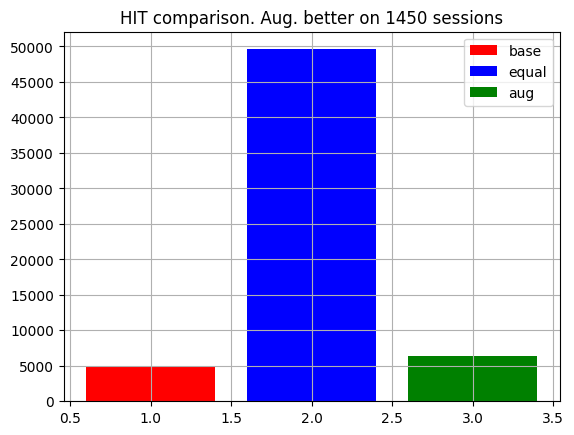

In [23]:
a,b,c=(sum(stats_df.base_hit>stats_df.aug_hit),
sum(stats_df.base_hit==stats_df.aug_hit),
sum(stats_df.base_hit<stats_df.aug_hit))
plt.title(f'HIT comparison. Aug. better on {c-a} sessions')
plt.bar([1,2, 3], height=[a,b,c],
label=['base','equal','aug'],
color=['red','blue','green'])
plt.yticks(np.arange(0,max(a,b,c)+5000, 5000))
plt.grid()
plt.legend()
plt.show()

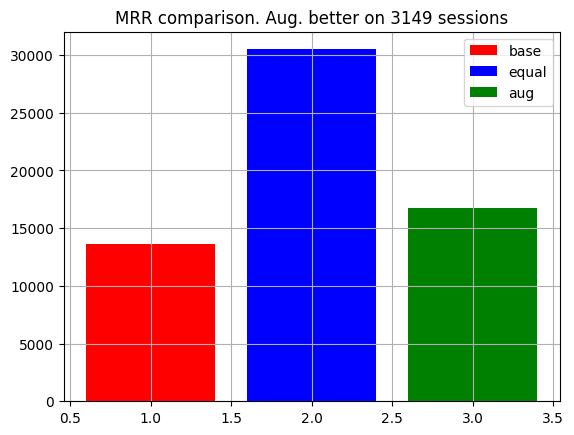

In [24]:
a,b,c=(sum(stats_df.base_mrr>stats_df.aug_mrr),
sum(stats_df.base_mrr==stats_df.aug_mrr),
sum(stats_df.base_mrr<stats_df.aug_mrr))

plt.title(f'MRR comparison. Aug. better on {c-a} sessions')
plt.bar([1,2, 3], height=[a,b,c], 
label=['base','equal','aug'],
color=['red','blue','green'])
plt.yticks(np.arange(0,max(a,b,c), 5000))
plt.grid()
plt.legend()
plt.show()

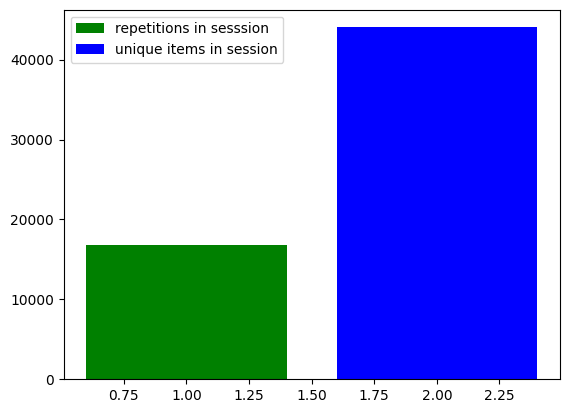

In [25]:
plt.bar([1,2], height=[
    sum(stats_df.repetitions_in_session),
    sum(~stats_df.repetitions_in_session)
], label=['repetitions in sesssion', 'unique items in session'],
color=['green', 'blue'])
plt.legend()
plt.show()

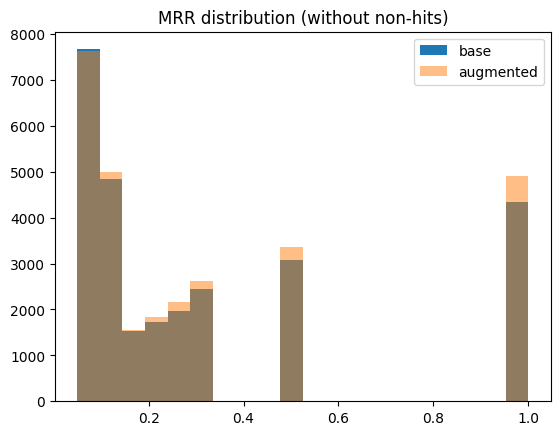

In [26]:
plt.hist(stats_df.base_mrr[stats_df.base_mrr>0], bins=20, label='base')
plt.hist(stats_df.aug_mrr[stats_df.aug_mrr>0], bins=20, label='augmented', alpha=0.5)
plt.legend()
plt.title('MRR distribution (without non-hits)')
plt.show()

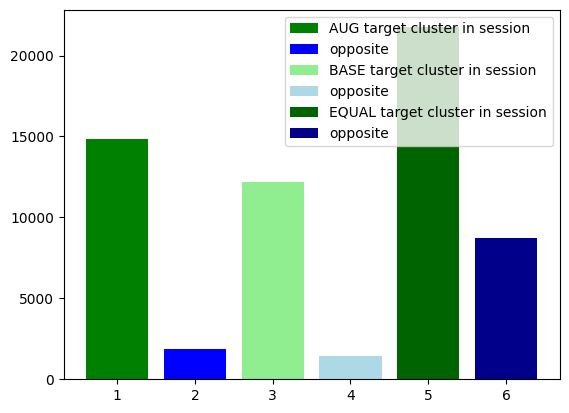

In [206]:
plt.bar([1,2,3,4,5,6], height=[
    sum(aug_df.target_cluster_in_ses),
    sum(~aug_df.target_cluster_in_ses),
    sum(base_df.target_cluster_in_ses),
    sum(~base_df.target_cluster_in_ses),
    sum(equal_df.target_cluster_in_ses),
    sum(~equal_df.target_cluster_in_ses)
], label=['AUG target cluster in session', 'opposite', 
          'BASE target cluster in session', 'opposite', 
          'EQUAL target cluster in session', 'opposite', ],
color=['green', 'blue', 'lightgreen', 'lightblue', 'darkgreen', 'darkblue'])
plt.legend()
plt.show()

#### repetitions, clusters & session len

In [51]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]

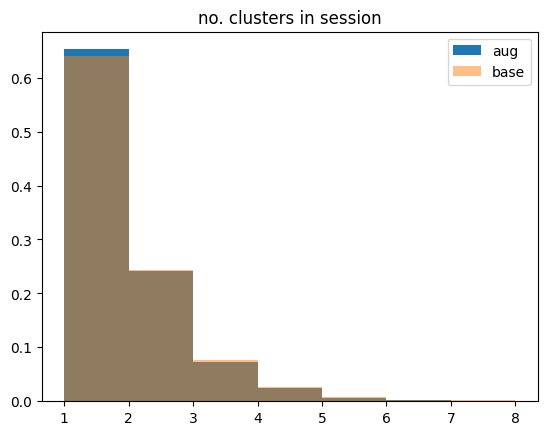

In [35]:

plt.title('no. clusters in session')
plt.hist(aug_df.no_clusters.values, bins=np.arange(stop=aug_df.no_clusters.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.no_clusters.values, bins=np.arange(stop=base_df.no_clusters.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.show()

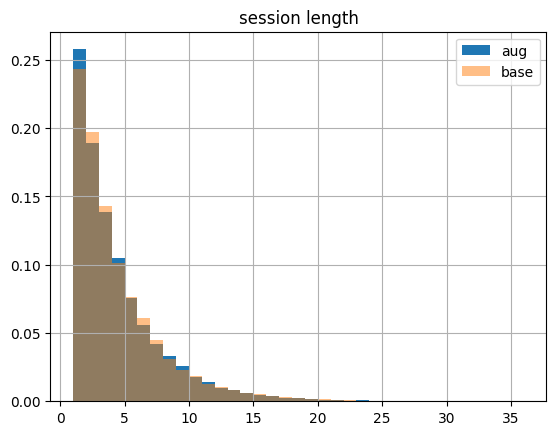

In [36]:
plt.title('session length')
plt.hist(aug_df.session_len.values, bins=np.arange(stop=aug_df.session_len.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.session_len.values, bins=np.arange(stop=base_df.session_len.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.grid()
plt.show()

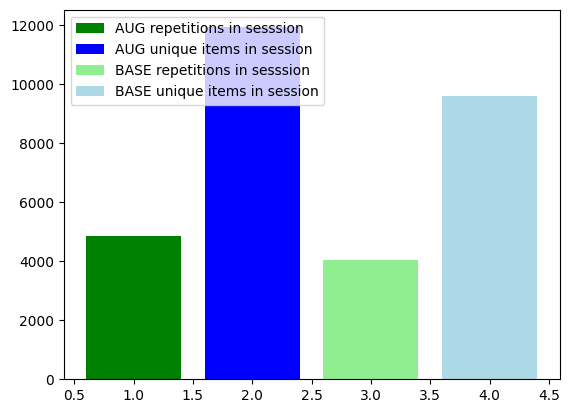

In [42]:
plt.bar([1,2,3,4], height=[
    sum(aug_df.repetitions_in_session),
    sum(~aug_df.repetitions_in_session),
    sum(base_df.repetitions_in_session),
    sum(~base_df.repetitions_in_session)
], label=['AUG repetitions in sesssion', 'AUG unique items in session', 'BASE repetitions in sesssion', 'BASE unique items in session'],
color=['green', 'blue', 'lightgreen', 'lightblue'])
plt.legend()
plt.show()

#### due to normalization, diff should be only on session with repetition. CHECK it

not really. Adjacency matrix indeed is different only then, but models weights differ all the time

In [108]:
rep_df=stats_df.loc[stats_df.repetitions_in_session]
print(rep_df.shape[0], ', Base hits:', sum(rep_df.base_hit), ', Aug hits:', sum(rep_df.aug_hit),
      '\n Percentage of different results:', np.round(100*sum(rep_df.base_mrr!=rep_df.aug_mrr)/rep_df.shape[0], 2),'%')

16813 , Base hits: 8428.0 , Aug hits: 8826.0 
 Percentage of different results: 52.74 %


In [109]:
notrep_df=stats_df.loc[~stats_df.repetitions_in_session]
print('Sessions without repetition! ', notrep_df.shape[0], ', Base hits:', sum(notrep_df.base_hit), ', Aug hits:', sum(notrep_df.aug_hit),
      '\n Percentage of different results:', np.round(100*sum(notrep_df.base_mrr!=notrep_df.aug_mrr)/notrep_df.shape[0], 2),'%')

Sessions without repetition!  44045 , Base hits: 19204.0 , Aug hits: 20256.0 
 Percentage of different results: 48.82 %


#### frequency

In [50]:
stats_df=stats_df.merge(items_df[['pricelog2','category','frequency','item_number']].rename(columns={'item_number':'target_number'}), 
             on='target_number',
             how='left')
stats_df['avg_sesssion_freq']=list(map(lambda ses: np.average([items_df.loc[items_df.item_number==x].frequency.item() for x in ses]) ,test_sessions))

In [92]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

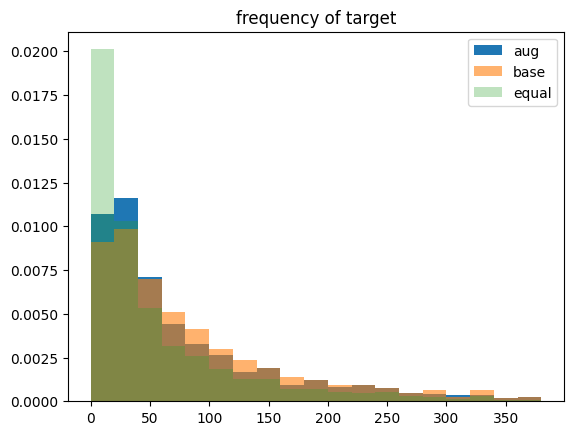

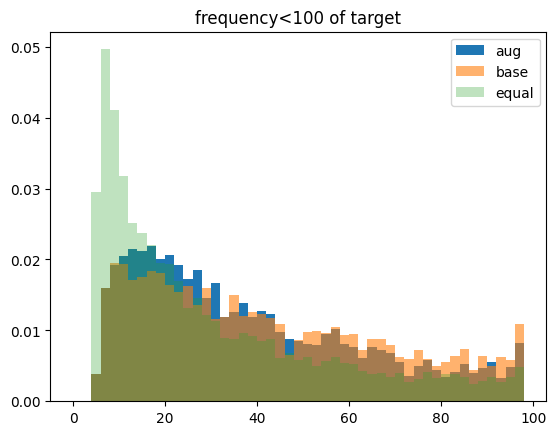

In [70]:

plt.title('frequency of target')
plt.hist(aug_df.frequency.values, bins=np.arange(400, step=20), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(400, step=20), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(400, step=20), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()


plt.title('frequency<100 of target')
plt.hist(aug_df.frequency.values, bins=np.arange(100, step=2), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(100, step=2), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(100, step=2), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

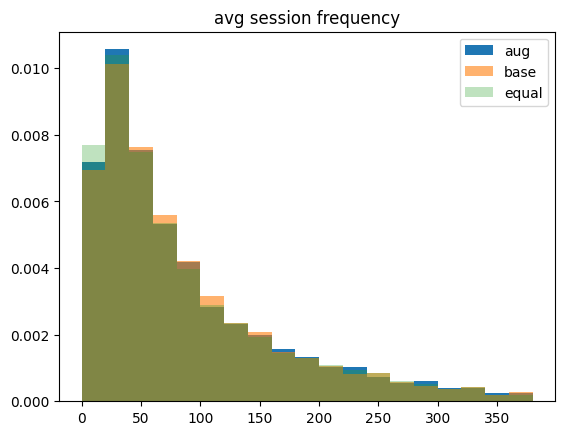

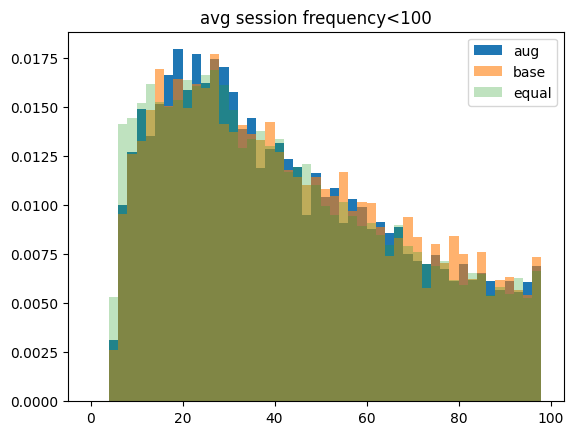

In [94]:

plt.title('avg session frequency')
plt.hist(aug_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), density=True, label='aug')
plt.hist(base_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), alpha=0.6, density=True, label='base')
plt.hist(equal_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()


plt.title('avg session frequency<100')
plt.hist(aug_df.avg_sesssion_freq.values, bins=np.arange(100, step=2), density=True, label='aug')
plt.hist(base_df.avg_sesssion_freq.values, bins=np.arange(100, step=2), alpha=0.6, density=True, label='base')
plt.hist(equal_df.avg_sesssion_freq.values, bins=np.arange(100, step=2), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

#### price

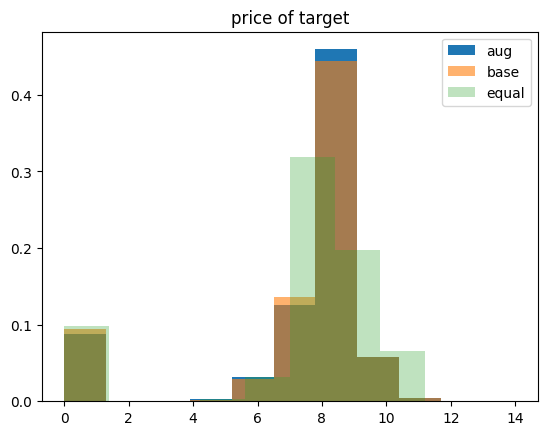

In [73]:
plt.title('price of target')
plt.hist(aug_df.pricelog2.values, bins=10, density=True, label='aug')
plt.hist(base_df.pricelog2.values, bins=10, alpha=0.6, density=True, label='base')
plt.hist(equal_df.pricelog2.values, bins=10, alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

#### embedding distance

In [97]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [99]:
base_items_embeddings=get_items_embedding(base_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
aug_items_embeddings=get_items_embedding(aug_model, torch.arange(items_df.item_number.nunique()+1, device=aug_model.device)).cpu().detach().numpy()

In [119]:
base_emb_center=np.average(base_items_embeddings, axis=0)
aug_emb_center=np.average(aug_items_embeddings, axis=0)

In [161]:
stats_df['base_sesssion_emb']=(list(map(lambda ses: np.average(base_items_embeddings[ses], axis=0) ,test_sessions)))
stats_df['aug_sesssion_emb']=list(map(lambda ses: np.average(aug_items_embeddings[ses], axis=0) ,test_sessions))


In [201]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

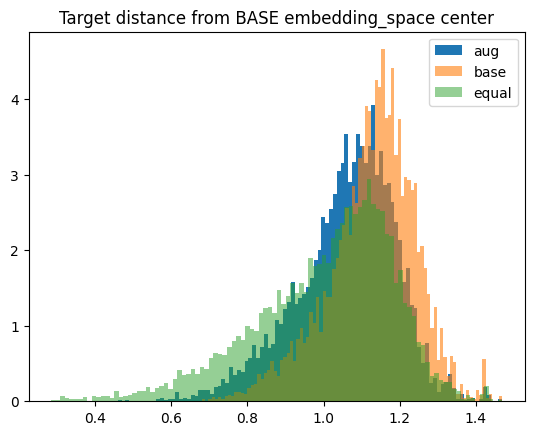

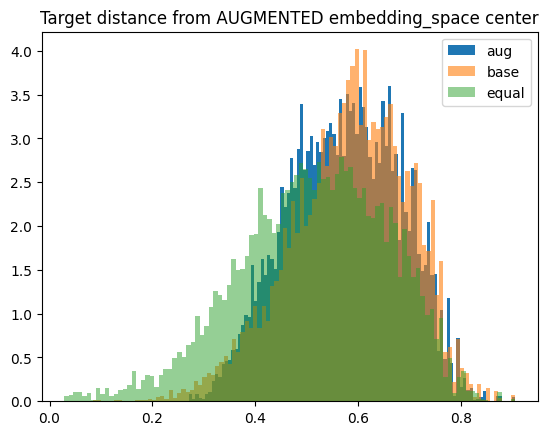

In [120]:

plt.title('Target distance from BASE embedding_space center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-base_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED embedding_space center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-aug_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



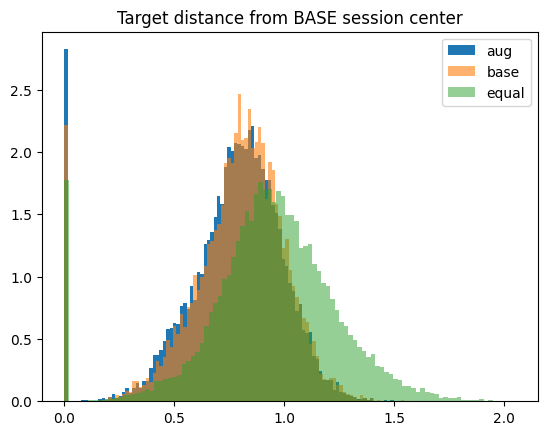

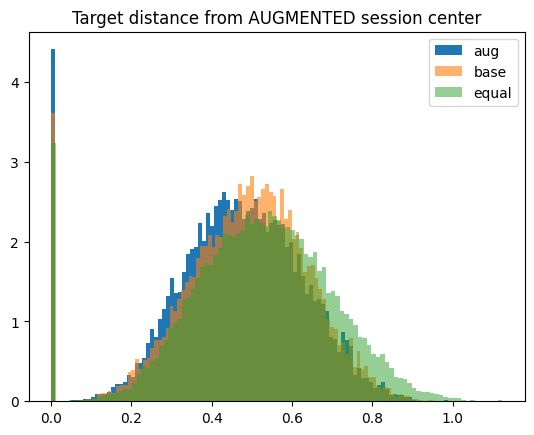

In [172]:

plt.title('Target distance from BASE session center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.base_sesssion_emb.values]), 
                        axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.base_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.base_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED session center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.aug_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



#### same but on clusters

In [173]:
with open(f"../datasets/{opt.dataset}/cluster_centers_16_{opt.hiddenSize}_{base_run_id.split('-')[-1]}.txt", 
            'rb') as f:
      cluster_centers=pickle.load(f)

In [194]:
#stats_df['cluster_sesssion_emb']=(list(map(lambda ses: np.average(cluster_centers[item_labels[ses]], axis=0) ,test_sessions)))
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

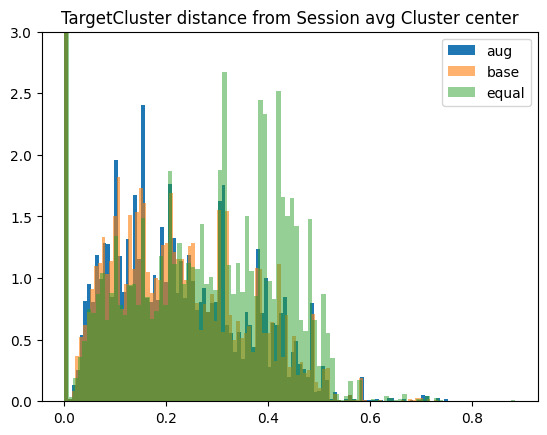

In [185]:

plt.title('TargetCluster distance from Session avg Cluster center')
plt.hist(np.linalg.norm(cluster_centers[item_labels[aug_df.target_number.values]]-np.asarray([x for x in aug_df.cluster_sesssion_emb.values]), 
                        axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(cluster_centers[item_labels[base_df.target_number.values]]-np.asarray([x for x in base_df.cluster_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(cluster_centers[item_labels[equal_df.target_number.values]]-np.asarray([x for x in equal_df.cluster_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.ylim(0, 3)
plt.show()

##### plot & compare embeddings

In [121]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [122]:
tsne=TSNE(2, init='random', early_exaggeration=32)
tsne_items_embeddings=tsne.fit_transform(aug_items_embeddings)

In [ ]:
fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced items embeddings from model with augmented adjacency matrix',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_AUGMATRIX_tsne{tsne.init}_{opt.dataset}_{opt.hiddenSize}_{base_run_id.split("-")[-1]}_{aug_run_id.split("-")[-1]}.html')
fig.show()

In [ ]:
tsne=TSNE(2, init='random', early_exaggeration=32)
tsne_items_embeddings=tsne.fit_transform(base_items_embeddings)


fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced items embeddings from model with augmented adjacency matrix',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_BASE_tsne{tsne.init}_{opt.dataset}_{opt.hiddenSize}_{base_run_id.split("-")[-1]}_{aug_run_id.split("-")[-1]}.html')
fig.show()

#### Categories

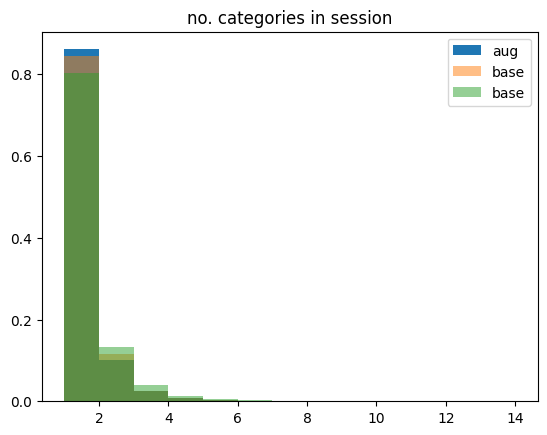

In [200]:

plt.title('no. categories in session')
plt.hist(aug_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.hist(equal_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


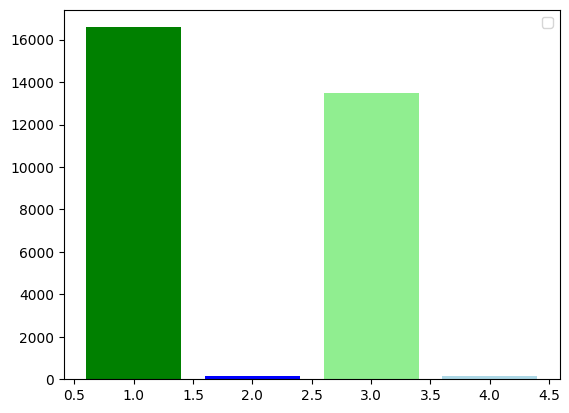

In [199]:
plt.bar([1,2,3,4], height=[
    sum(aug_df.target_category_in_ses),
    sum(~aug_df.target_category_in_ses),
    sum(base_df.target_category_in_ses),
    sum(~base_df.target_category_in_ses)
], #label=['AUG repetitions in sesssion', 'AUG unique items in session', 'BASE repetitions in sesssion', 'BASE unique items in session'],
color=['green', 'blue', 'lightgreen', 'lightblue'])
plt.legend()
plt.show()